### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from bayes_opt import BayesianOptimization

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

#### Prepare kfolds

In [11]:
n_folds = 3
feat_engs = []
df_trains = []
df_vals = []
folds = KFold(n_splits=n_folds, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]

    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    feat_engs.append(feat_eng)
    df_trains.append(df_train)
    df_vals.append(df_val)

#### Bayesian Optimization

In [12]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              }
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

In [13]:
np.log10(np.array([0,0.001,0.01,0.1, 1])+0.0001)

array([-4.00000000e+00, -2.95860731e+00, -1.99567863e+00, -9.99565923e-01,
        4.34272769e-05])

In [14]:
10**(np.log10(np.array([0,0.001,0.1, 1])+0.0001))-0.0001

array([0.e+00, 1.e-03, 1.e-01, 1.e+00])

In [15]:
# list of params that are scaned in log scale (take np.log1p(input) as params)
log_params = ['num_leaves']  

# list of params doing log but in scale less than 1 (take np.log10(x + 0.0001)) as input
log10small_params = ['lambda_l1', 'lambda_l2']
log10small_scale = 0.0001
def log10small_transform(x): return np.log10(x + log10small_scale)

# list of params that needs to be int
int_params = ['num_leaves', 'min_data_in_leaf', 'max_depth']

# depth threshold (above which the model will treat it as no limit on max_depth)
max_depth_threshold = 10

def fix_params(params):
    """Fix the params"""
    for c in log_params:
        if c in params: 
            params[c] = np.expm1(params[c])
        
    for c in int_params:
        if c in params: 
            params[c] = int(round(params[c]))
    
    for c in log10small_params:
        if c in params: 
            params[c] = np.clip(10**params[c] - log10small_scale, a_min=0, a_max=None)
        
    if 'max_depth' in params and params['max_depth'] > max_depth_threshold:
        params['max_depth'] = -1    
    return params

In [16]:
def kfold_cv(**params_update):
    params_update = fix_params(params_update)
    params = params_fix.copy()
    params.update(params_update)
    
    print('==', params, '==')
    
    scores = []
    scores2 = []
    for i_fold, (df_train, df_val) in enumerate(zip(df_trains, df_vals)):
        print('==== Fold', i_fold+1, '====')

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = mean_squared_log_error(df_val['total_price'], y_pred_final)
        score2 = cal_score(df_val['total_price'], y_pred_final)
        
        scores.append(score)
        scores2.append(score2)
    
    tuple_params = tuple(params.items())
    result = [tuple_params, np.mean(scores), scores, np.mean(scores2), scores2]
    print(result)    
    gsearch_results.append(result)
    return result[3]

In [17]:
gsearch_results = []

In [18]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'learning_rate': (0.01, 0.02),
    'num_leaves': (np.log1p(63), np.log1p(511)),           # may reduce in dim-reduction exp
    'feature_fraction': (0.1, 1.0),
    'min_data_in_leaf': (5, 100),
    'lambda_l1': (log10small_transform(0.), log10small_transform(1.)),
    'lambda_l2': (log10small_transform(0.), log10small_transform(1.)),
    'max_depth': (5, max_depth_threshold+1),
}

optimizer = BayesianOptimization(
    f=kfold_cv,
    pbounds=pbounds,
    random_state=1,
)

In [19]:
pbounds

{'learning_rate': (0.01, 0.02),
 'num_leaves': (4.1588830833596715, 6.238324625039508),
 'feature_fraction': (0.1, 1.0),
 'min_data_in_leaf': (5, 100),
 'lambda_l1': (-4.0, 4.342727686266486e-05),
 'lambda_l2': (-4.0, 4.342727686266486e-05),
 'max_depth': (5, 11)}

In [20]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=65,
)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.47531980423231657, 'lambda_l1': 0.07599029283590257, 'lambda_l2': 1.0539975000130276e-07, 'learning_rate': 0.013023325726318398, 'max_depth': 6, 'min_data_in_leaf': 14, 'num_leaves': 93} ==
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00975815
[4000]	valid_0's mape: 0.00925269
[6000]	valid_0's mape: 0.00899931
[8000]	valid_0's mape: 0.00885929
[10000]	valid_0's mape: 0.0087745
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0087745
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00974974
[4000]	valid_0's mape: 0.00927115
[6

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00906405
[4000]	valid_0's mape: 0.00885346
[6000]	valid_0's mape: 0.00880402
[8000]	valid_0's mape: 0.00878682
[10000]	valid_0's mape: 0.00877871
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00877871
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00919535
[4000]	valid_0's mape: 0.00899056
[6000]	valid_0's mape: 0.00894347
[8000]	valid_0's mape: 0.00892485
[10000]	valid_0's mape: 0.00891664
Did not meet early stopping. Best iteration is:
[9993]	valid_0's mape: 0.00891664
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00926311
[4000]	valid_0's mape: 0.00905536
[6000]	valid_0's mape: 0.00900514
[8000]	valid_0's mape: 0.00898538
[10000]	valid_0's mape: 0.00897577
Did not meet early stopping. Best iteration is:
[9990]	valid_0's mape: 0.00897576
[(('task', 'tr

[2000]	valid_0's mape: 0.00970872
[4000]	valid_0's mape: 0.00930813
[6000]	valid_0's mape: 0.00913142
[8000]	valid_0's mape: 0.00903082
[10000]	valid_0's mape: 0.00896257
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00896257
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.009793
[4000]	valid_0's mape: 0.00937254
[6000]	valid_0's mape: 0.00917229
[8000]	valid_0's mape: 0.0090572
[10000]	valid_0's mape: 0.00899644
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00899637
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.6167058449428118), ('lambda_l1', 0.0002862964095966356), ('lambda_l2', 0.022663956107450308), ('learning_rate', 0.016997583600209313), ('max_depth', 6), ('min_data_in_leaf', 44), ('num_leaves', 270)), 0.042556204414643084, [0.041263435064223225, 0.042623879996857475, 0.043781298182848545], 5231.189851

[2000]	valid_0's mape: 0.00915628
[4000]	valid_0's mape: 0.00883879
[6000]	valid_0's mape: 0.00872651
[8000]	valid_0's mape: 0.00867676
[10000]	valid_0's mape: 0.0086476
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0086476
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.3663254710891207), ('lambda_l1', 0.13147541342160604), ('lambda_l2', 0.00018213462422180925), ('learning_rate', 0.01452946760763927), ('max_depth', 10), ('min_data_in_leaf', 33), ('num_leaves', 117)), 0.04051251791825253, [0.039068331647348215, 0.040880875570526186, 0.04158834653688318], 5472.862933609448, [5508.864505463616, 5430.86454897369, 5478.859746391038]]
|  13       |  5.473e+0 |  0.3663   | -0.8808   | -3.55     |  0.01453  |  10.46    |  32.9     |  4.769    |
== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.11621268051986595, 'lambda_l1': 0.004632790580929924,

== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.9379794553574694, 'lambda_l1': 0.00031990107140214997, 'lambda_l2': 0.5848493087330571, 'learning_rate': 0.011657308917931817, 'max_depth': 8, 'min_data_in_leaf': 60, 'num_leaves': 66} ==
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00977191
[4000]	valid_0's mape: 0.00935671
[6000]	valid_0's mape: 0.00918653
[8000]	valid_0's mape: 0.00908277
[10000]	valid_0's mape: 0.00902749
Did not meet early stopping. Best iteration is:
[9995]	valid_0's mape: 0.00902742
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00982798
[4000]	valid_0's mape: 0.00941587
[6000]	valid_0's mape: 0.00923152
[8000]	valid_0's mape: 0.00912414
[10000]	valid_0's mape: 0.0090606
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0090606
==== Fold 3 ====
Training until validat

[2000]	valid_0's mape: 0.00954038
[4000]	valid_0's mape: 0.00923302
[6000]	valid_0's mape: 0.00910452
[8000]	valid_0's mape: 0.00904546
[10000]	valid_0's mape: 0.00901582
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00901577
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00956946
[4000]	valid_0's mape: 0.00925988
[6000]	valid_0's mape: 0.0091345
[8000]	valid_0's mape: 0.00906118
[10000]	valid_0's mape: 0.0090249
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0090249
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00964698
[4000]	valid_0's mape: 0.00934689
[6000]	valid_0's mape: 0.00922906
[8000]	valid_0's mape: 0.00916395
[10000]	valid_0's mape: 0.00913108
Did not meet early stopping. Best iteration is:
[9996]	valid_0's mape: 0.00913107
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 

[6000]	valid_0's mape: 0.00889406
[8000]	valid_0's mape: 0.00882922
[10000]	valid_0's mape: 0.00879432
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00879431
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00950378
[4000]	valid_0's mape: 0.00914381
[6000]	valid_0's mape: 0.00901827
[8000]	valid_0's mape: 0.00895351
[10000]	valid_0's mape: 0.00891816
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00891816
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.9088395194464667), ('lambda_l1', 0.06024310470051436), ('lambda_l2', 0.00145421632875538), ('learning_rate', 0.012706587332466667), ('max_depth', 8), ('min_data_in_leaf', 7), ('num_leaves', 132)), 0.04368250956642289, [0.04321093901018469, 0.043321331549794666, 0.044515258139289304], 5403.191940349668, [5422.858845431001, 5405.86121198819, 5380.855763629811]]
|  26

[8000]	valid_0's mape: 0.00905797
[10000]	valid_0's mape: 0.00900976
Did not meet early stopping. Best iteration is:
[9996]	valid_0's mape: 0.00900975
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.6249274388267846), ('lambda_l1', 0.0004457951705494274), ('lambda_l2', 0.011875310812600867), ('learning_rate', 0.01951250941325543), ('max_depth', 7), ('min_data_in_leaf', 78), ('num_leaves', 164)), 0.04273588284303492, [0.04159002420846231, 0.04255285129882324, 0.0440647730218192], 5276.5235208701115, [5287.857921916117, 5256.858938405402, 5284.853702288815]]
|  30       |  5.277e+0 |  0.6249   | -3.263    | -1.922    |  0.01951  |  7.419    |  78.48    |  5.104    |
== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.4103401277966163, 'lambda_l1': 0.0010614215829512403, 'lambda_l2': 0.0997073335419222, 'learning_rate': 0.017560240858512436, 'max_depth': 7, 'min_data_in_l

== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.12889034067223554, 'lambda_l1': 0.0001416136016735992, 'lambda_l2': 0.004422116329582848, 'learning_rate': 0.018868694365407945, 'max_depth': 8, 'min_data_in_leaf': 27, 'num_leaves': 252} ==
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00974567
[4000]	valid_0's mape: 0.00924434
[6000]	valid_0's mape: 0.00905926
[8000]	valid_0's mape: 0.00897236
[10000]	valid_0's mape: 0.00892515
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00892515
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00986247
[4000]	valid_0's mape: 0.00934486
[6000]	valid_0's mape: 0.00916466
[8000]	valid_0's mape: 0.00907446
[10000]	valid_0's mape: 0.00903149
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00903149
==== Fold 3 ====
Training until v

[4000]	valid_0's mape: 0.00886879
[6000]	valid_0's mape: 0.00869771
[8000]	valid_0's mape: 0.00860869
[10000]	valid_0's mape: 0.00855555
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00855555
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0093662
[4000]	valid_0's mape: 0.0089736
[6000]	valid_0's mape: 0.00881259
[8000]	valid_0's mape: 0.00872491
[10000]	valid_0's mape: 0.00867251
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00867251
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00941147
[4000]	valid_0's mape: 0.00902488
[6000]	valid_0's mape: 0.00886456
[8000]	valid_0's mape: 0.00877791
[10000]	valid_0's mape: 0.00872709
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00872709
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.

[6000]	valid_0's mape: 0.00888116
[8000]	valid_0's mape: 0.00880315
[10000]	valid_0's mape: 0.0087494
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0087494
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00944931
[4000]	valid_0's mape: 0.00911131
[6000]	valid_0's mape: 0.00896073
[8000]	valid_0's mape: 0.00888297
[10000]	valid_0's mape: 0.00883559
Did not meet early stopping. Best iteration is:
[9995]	valid_0's mape: 0.00883553
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.6476961766690726), ('lambda_l1', 0.15136674150960253), ('lambda_l2', 0.5052079876060864), ('learning_rate', 0.010893829541225267), ('max_depth', 9), ('min_data_in_leaf', 43), ('num_leaves', 409)), 0.04195984866110145, [0.040733146876061256, 0.04198941562812058, 0.043156983479122515], 5388.526473138555, [5414.861259402133, 5373.86143538152, 5376.856724632012]]
|  43  

[10000]	valid_0's mape: 0.00879063
Did not meet early stopping. Best iteration is:
[9988]	valid_0's mape: 0.00879057
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.5139134247089524), ('lambda_l1', 0.006548713202330196), ('lambda_l2', 0.0029494447767572083), ('learning_rate', 0.01738484975812249), ('max_depth', 10), ('min_data_in_leaf', 50), ('num_leaves', 75)), 0.04148513594944172, [0.04004974798596392, 0.041554839247352274, 0.042850820615008965], 5413.860436576432, [5442.86188780783, 5400.862320414298, 5397.857101507169]]
|  47       |  5.414e+0 |  0.5139   | -2.177    | -2.516    |  0.01738  |  9.566    |  50.0     |  4.324    |
== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.4606993886681101, 'lambda_l1': 0.0001545154469379011, 'lambda_l2': 0.0021394522521463928, 'learning_rate': 0.019999461870507305, 'max_depth': 9, 'min_data_in_leaf': 57, 'num_leaves': 332} =

== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.9269850291634248, 'lambda_l1': 0.06978120505805696, 'lambda_l2': 0.011999759942734337, 'learning_rate': 0.011050760811189858, 'max_depth': -1, 'min_data_in_leaf': 11, 'num_leaves': 356} ==
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00888051
[4000]	valid_0's mape: 0.00877748
[6000]	valid_0's mape: 0.00875414
[8000]	valid_0's mape: 0.00874563
[10000]	valid_0's mape: 0.00874203
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00874203
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00887521
[4000]	valid_0's mape: 0.00877398
[6000]	valid_0's mape: 0.00874908
[8000]	valid_0's mape: 0.00874064
[10000]	valid_0's mape: 0.00873691
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00873691
==== Fold 3 ====
Training until val

[4000]	valid_0's mape: 0.00898718
[6000]	valid_0's mape: 0.00881341
[8000]	valid_0's mape: 0.00872144
[10000]	valid_0's mape: 0.00867017
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00867014
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00943583
[4000]	valid_0's mape: 0.00904451
[6000]	valid_0's mape: 0.00887933
[8000]	valid_0's mape: 0.00879542
[10000]	valid_0's mape: 0.00874172
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00874172
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00947083
[4000]	valid_0's mape: 0.00910996
[6000]	valid_0's mape: 0.00894462
[8000]	valid_0's mape: 0.00886625
[10000]	valid_0's mape: 0.00881892
Did not meet early stopping. Best iteration is:
[9963]	valid_0's mape: 0.00881858
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0

[8000]	valid_0's mape: 0.00893017
[10000]	valid_0's mape: 0.00886623
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00886623
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00962323
[4000]	valid_0's mape: 0.00922136
[6000]	valid_0's mape: 0.00904739
[8000]	valid_0's mape: 0.00895051
[10000]	valid_0's mape: 0.00889643
Did not meet early stopping. Best iteration is:
[9988]	valid_0's mape: 0.00889629
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.5537730001370738), ('lambda_l1', 0.002430936106510772), ('lambda_l2', 0.007091443320162015), ('learning_rate', 0.015278220143981322), ('max_depth', 7), ('min_data_in_leaf', 49), ('num_leaves', 74)), 0.04186468370919021, [0.04039731228134355, 0.042091490763833124, 0.04310524808239396], 5307.524972760788, [5322.859837199493, 5278.859675293766, 5320.855405789105]]
|  60       |  5.308e+0 |  0.5538   |

[10000]	valid_0's mape: 0.00897239
Did not meet early stopping. Best iteration is:
[9993]	valid_0's mape: 0.00897239
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.902141198103063), ('lambda_l1', 0.001712418772836806), ('lambda_l2', 0.0007144205275487949), ('learning_rate', 0.012544280594197493), ('max_depth', 9), ('min_data_in_leaf', 30), ('num_leaves', 229)), 0.043598449666767354, [0.042923885976782226, 0.043279777077780954, 0.0445916859457389], 5369.524328048316, [5379.85840642662, 5371.860280418277, 5356.854297300052]]
|  64       |  5.37e+03 |  0.9021   | -2.742    | -3.089    |  0.01254  |  8.959    |  30.33    |  5.44     |
== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.690530508811587, 'lambda_l1': 6.507924512245836e-06, 'lambda_l2': 0.024321297756570767, 'learning_rate': 0.01698774313444896, 'max_depth': 6, 'min_data_in_leaf': 63, 'num_leaves': 404} ==
=

== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.8176289287983561, 'lambda_l1': 0.14425537580114467, 'lambda_l2': 0.00033854736627533615, 'learning_rate': 0.01156345047124472, 'max_depth': 10, 'min_data_in_leaf': 73, 'num_leaves': 216} ==
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00947954
[4000]	valid_0's mape: 0.00914665
[6000]	valid_0's mape: 0.00899418
[8000]	valid_0's mape: 0.0089162
[10000]	valid_0's mape: 0.00887023
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00887019
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00949828
[4000]	valid_0's mape: 0.0091763
[6000]	valid_0's mape: 0.00902616
[8000]	valid_0's mape: 0.00894789
[10000]	valid_0's mape: 0.00889817
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00889817
==== Fold 3 ====
Training until valid

[4000]	valid_0's mape: 0.00942526
[6000]	valid_0's mape: 0.00921606
[8000]	valid_0's mape: 0.00909184
[10000]	valid_0's mape: 0.00902061
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00902056
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00986447
[4000]	valid_0's mape: 0.0094837
[6000]	valid_0's mape: 0.00928464
[8000]	valid_0's mape: 0.00916813
[10000]	valid_0's mape: 0.0090893
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0090893
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00993913
[4000]	valid_0's mape: 0.0095609
[6000]	valid_0's mape: 0.00935753
[8000]	valid_0's mape: 0.00923128
[10000]	valid_0's mape: 0.00916283
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00916281
[(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('feature_fraction', 0.693

In [21]:
optimizer.max

{'target': 5493.529847274412,
 'params': {'feature_fraction': 0.36578099436157574,
  'lambda_l1': -0.8818891483244172,
  'lambda_l2': -3.5498225113573385,
  'learning_rate': 0.01447864739472235,
  'max_depth': 10.461898275943284,
  'min_data_in_leaf': 32.89797806329801,
  'num_leaves': 4.768422346080482}}

In [22]:
gsearch_results.sort(key= lambda x: x[3], reverse=True)

In [23]:
gsearch_results

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('feature_fraction', 0.36578099436157574),
   ('lambda_l1', 0.13115348747766442),
   ('lambda_l2', 0.00018195349910156503),
   ('learning_rate', 0.01447864739472235),
   ('max_depth', 10),
   ('min_data_in_leaf', 33),
   ('num_leaves', 117)),
  0.040412726175333695,
  [0.039030343394461646, 0.04077395913722275, 0.04143387599431669],
  5493.529847274412,
  [5512.864670228509, 5452.864634669553, 5514.860236925176]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('feature_fraction', 0.3523995928579646),
   ('lambda_l1', 0.14349905769724033),
   ('lambda_l2', 0.0001587667725408276),
   ('learning_rate', 0.014478935261759052),
   ('max_depth', 10),
   ('min_data_in_leaf', 33),
   ('num_leaves', 115)),
  0.04047685885496762,
  [0.039030614696652734, 0.04073091170737613, 0.041669050160873994],
  5489.196261332105,
  [5522.864677400221,

### Plots

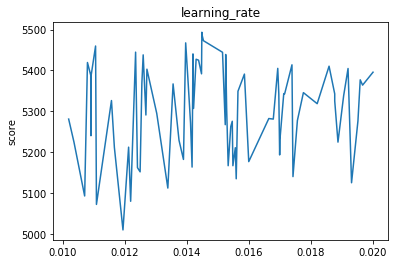

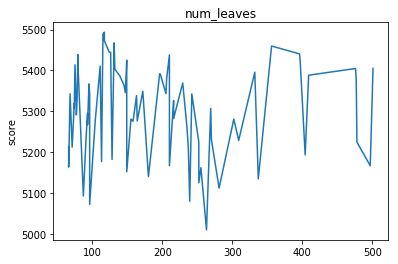

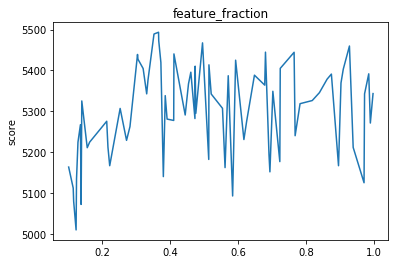

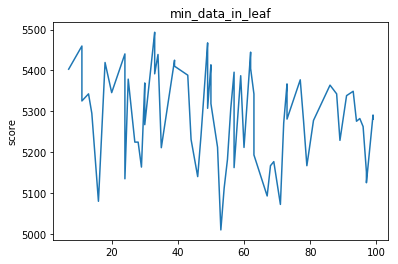

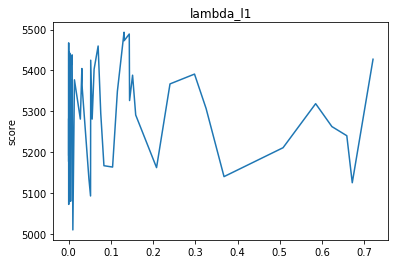

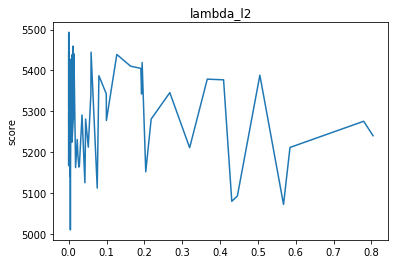

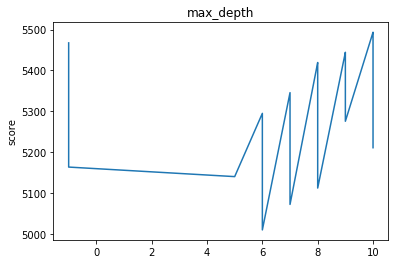

In [24]:
for param_name in pbounds:
    x_y = [[dict(row[0])[param_name], row[3]] for row in gsearch_results]
    x_y.sort(key=lambda xy: xy[0])
    x_y = np.array(x_y)
    plt.plot(x_y[:, 0], x_y[:, 1])
    plt.title(param_name); plt.ylabel('score')
    plt.show()

### Conclusion

- Round 1 best params (random seed = 123):
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5)),  

Best scores: 5501.863278855861  
[5527.864888142274, 5498.864225711784, 5478.860722713526]

- Round 2 best params (random seed = 123):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0)  
  
Best scores: *5515.529915334645*  
[5532.864763855017, 5514.864357360793, 5498.860624788125]

- Round 2 best params (random seed = 246):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0.1)  
   
Best scores: *5524.863045737181*  
[5528.862755759428, 5530.862894274216, 5514.863487177898]

### Other info

In [ ]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5)
plt.show()

In [ ]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain')
plt.show()